In [ ]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import read_csv
import io
import matplotlib.pyplot as plt
from numpy import array
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
upload=files.upload()

Saving btc.csv to btc.csv


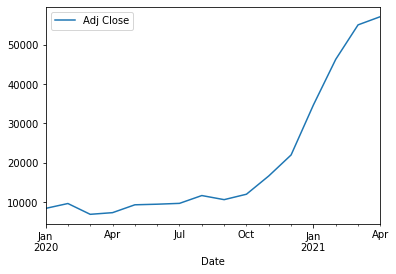

,Adj Close
count,16.000000
mean,20424.460174
std,17627.627922
min,6884.913984
25%,9419.738810
50%,11137.227691
75%,25163.116179
max,57164.461458


In [ ]:
series1 = pd.read_csv('btc.csv',header=0,index_col=0,parse_dates=True)
series1=series1.groupby(pd.Grouper(freq='M'))['Adj Close'].mean()
series1=pd.DataFrame(series1)
series1.plot()
plt.show()
series1.describe()

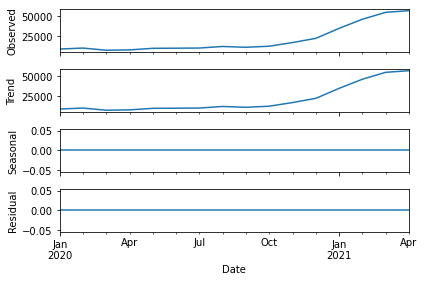

In [ ]:
result1 = seasonal_decompose(series1,freq=1, model='additive')
result1.plot();

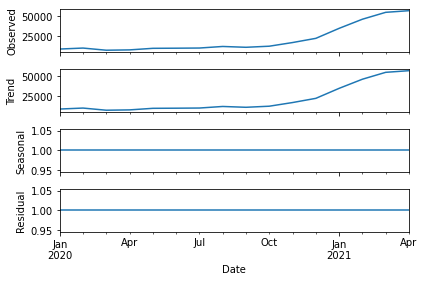

In [ ]:
result2 = seasonal_decompose(series1,freq=1, model='multiplicative')
result2.plot();

In [ ]:
def exp_smoothing_forecast(history, config):
	t,d,s,p,b,r = config
	# define model
	history = array(history)
	model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
	# fit model
	model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

In [ ]:
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

In [ ]:
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

In [ ]:
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

In [ ]:
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

In [ ]:
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores
 

In [ ]:
def exp_smoothing_configs(seasonal=[None]):
	models = list()
	# define config lists
	t_params = ['add', 'mul', None]
	d_params = [True, False]
	s_params = ['add', 'mul', None]
	p_params = seasonal
	b_params = [True, False]
	r_params = [True, False]
	# create config instances
	for t in t_params:
		for d in d_params:
			for s in s_params:
				for p in p_params:
					for b in b_params:
						for r in r_params:
							cfg = [t,d,s,p,b,r]
							models.append(cfg)
	return models

In [ ]:
	data = series1.values
	# data split
	n_test = 4
	# model configs
	cfg_list = exp_smoothing_configs()
	# grid search
	scores = grid_search(data[:,0], cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[['add', True, None, None, False, True]] 5974.133
 > Model[['add', True, None, None, True, True]] 12756.118
 > Model[['add', True, None, None, False, False]] 5839.269
 > Model[['add', True, None, None, True, False]] 13679.183
 > Model[['add', False, None, None, True, True]] 67525.664
 > Model[['add', False, None, None, True, False]] 68247.642
 > Model[['add', False, None, None, False, True]] 6023.514
 > Model[['add', False, None, None, False, False]] 5932.218
 > Model[['mul', False, None, None, True, True]] 39114.437
 > Model[['mul', False, None, None, True, False]] 39048.622
 > Model[['mul', False, None, None, False, True]] 10751.144
 > Model[['mul', False, None, None, False, False]] 10180.426
 > Model[[None, False, None, None, True, True]] 9359.136
 > Model[[None, False, None, None, True, False]] 11100.231
 > Model[[None, False, None, None, False, True]] 8230.081
 > Model[[None, False, None, None, False, False]] 9716.346
 > Model[['mul', True, None, None, False, True]] 8204.2

In [ ]:
cfg_test=['add', True, None, None, False, False]

In [ ]:
def walk_forward_validation_test(data, n_test, cfg_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = exp_smoothing_forecast(history, cfg_test)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error,predictions,test

In [ ]:
mse,predictions,test = walk_forward_validation_test(series1['Adj Close'], n_test,cfg_test)
forecast = [x for x in predictions]
print(mse)

5839.268673589181


In [ ]:
df=pd.DataFrame(forecast,index=series1.index[-n_test:],columns=['Forecast'])
df.dropna(inplace=True)
df['Actual']=series1['Adj Close'][-n_test:]
df['difference']=df['Forecast']-df['Actual']
df.head()

,Forecast,Actual,difference
Date,,,
2021-01-31,25837.541953,34703.053427,-8865.511474
2021-02-28,45739.986108,46306.798968,-566.812860
2021-03-31,58303.672806,55070.438886,3233.233919
2021-04-30,64021.272851,57164.461458,6856.811392


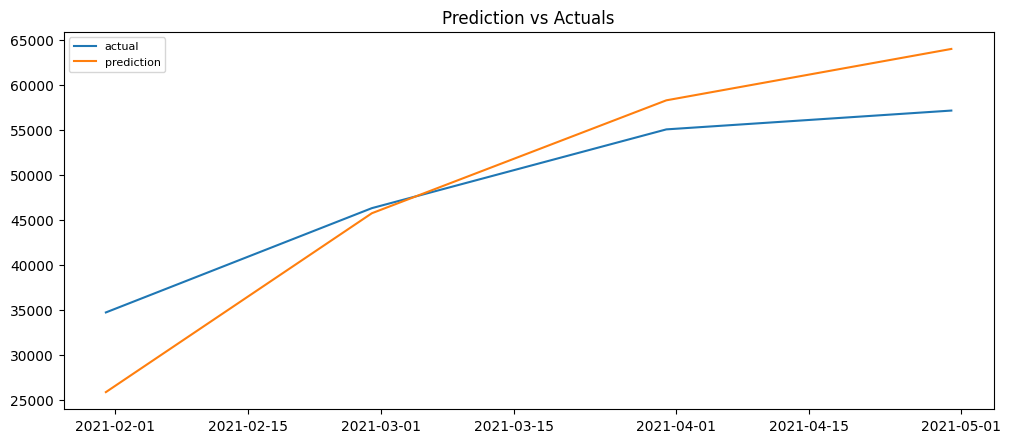

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df['Actual'], label='actual')
plt.plot(df['Forecast'], label='prediction')
plt.title('Prediction vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()